In [40]:
import numpy as np
import uproot
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

plt.rc("font", family=["Helvetica", "Arial"]) # skifter skrifttype
plt.rc("axes", labelsize=22)   # skriftstørrelse af `xlabel` og `ylabel`
plt.rc("xtick", labelsize=22, top=True, direction="out")
plt.rc("ytick", labelsize=22, right=True, direction="out")
plt.rc("axes", titlesize=22)
plt.rc("legend", fontsize=18)
plt.rcParams["figure.figsize"] = (8, 6)

In [41]:
def flatten_array(arr):
    flattened = []
    for sub in arr[:]:
        flattened = np.concatenate((flattened, sub))
    return flattened
def reject_outliers(data, x, m=5):
    idxs = abs(data - np.mean(data)) < m * np.std(data)
    return data[idxs], x[idxs]
def gaussian(x, amplitude, mean, standard_deviation, b):
    return amplitude * np.exp( - (x - mean)**2 / (2*standard_deviation ** 2)) + b

In [43]:
files = ['OutDir_{}/hist-Rel21sample.root'.format(i) for i in range(1, 6)]
tr_vtx_zs = np.array([], dtype='object')
tr_vtx_ts = np.array([], dtype='object')
re_vtx_zs = np.array([], dtype='object')

for file in files:
    root_file = uproot.open(file)
    for key in root_file.keys():
        if key.startswith('EventTree'):
            tree = root_file[key]
            tr_vtx_zs = np.concatenate((tr_vtx_zs, tree['truthvertex_z'].array(library='np')))
            tr_vtx_ts = np.concatenate((tr_vtx_ts, tree['truthvertex_t'].array(library='np')))
            re_vtx_zs = np.concatenate((re_vtx_zs, tree['recovertex_z'].array(library='np')))

In [44]:
delta_z = np.array([])
# For each event compare all V_truth and V_reco z-positions
for tr_zs, re_zs in zip(tr_vtx_zs, re_vtx_zs):
    xv, yv = np.meshgrid(tr_zs, re_zs)
    delta_z = np.concatenate((delta_z, np.subtract(xv, yv).flatten()))

np.min(delta_z), np.max(delta_z), np.mean(delta_z), np.std(delta_z)

(-310.2735290527344, 303.64178466796875, 0.4143093016880596, 64.60588106056487)

Text(0.5, 0, '$\\Delta z$ (mm)')

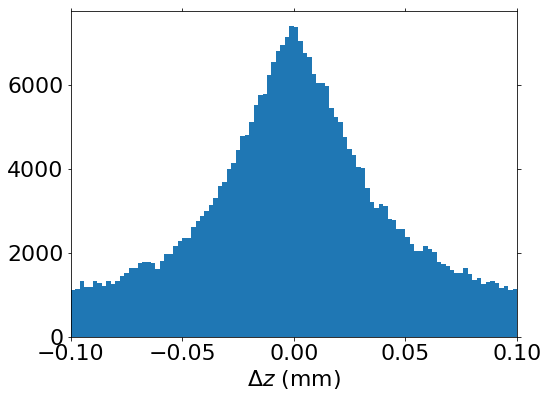

In [45]:
z_lim = 0.1
_= plt.hist(delta_z[np.abs(delta_z) < z_lim], 100)
plt.xlim(-z_lim, z_lim)
plt.xlabel('$\\Delta z$ (mm)')

In [79]:
## Background test
delta_z_bkg = np.array([])
for i in range(tr_vtx_zs.shape[0]):
    z1 = np.random.normal(scale=45, size=tr_vtx_zs[i].shape[0]-1)
    z2 = np.random.normal(scale=45, size=re_vtx_zs[i].shape[0]-1)
    xv, yv = np.meshgrid(z1, z2)
    delta_z_bkg = np.concatenate((delta_z_bkg, np.subtract(xv, yv).flatten()))

np.min(delta_z_bkg), np.max(delta_z_bkg), np.mean(delta_z_bkg), np.std(delta_z_bkg)

(-369.40712382598167,
 352.9215224273622,
 0.08381679813879676,
 63.54008567937202)

Text(0.5, 0, '$\\Delta z$ (mm)')

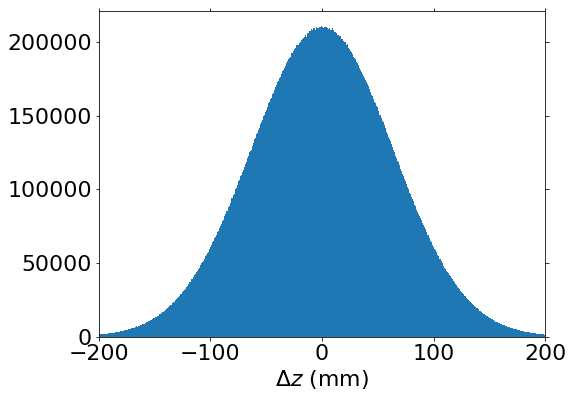

In [80]:
z_lim = 200
_= plt.hist(delta_z_bkg[np.abs(delta_z_bkg) < z_lim], 700)
plt.xlim(-z_lim, z_lim)
plt.xlabel('$\\Delta z$ (mm)')

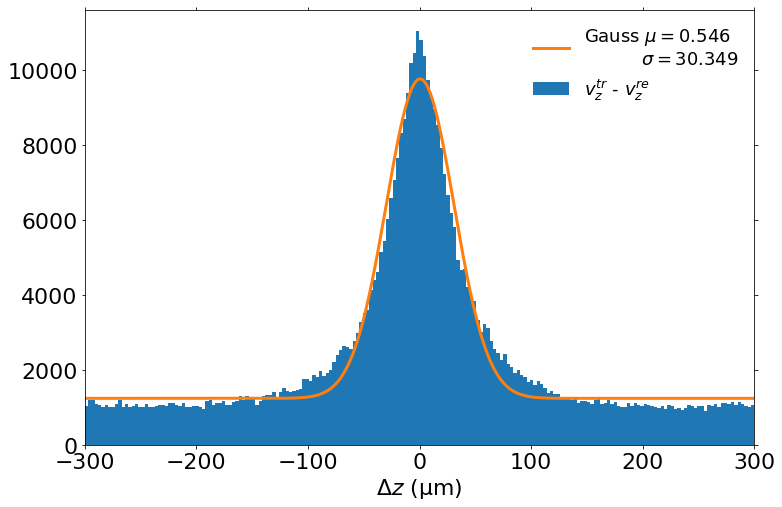

In [47]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(12, 8)

dz_max = 300

bin_heights, bin_borders, _ = ax.hist(1e3*delta_z    [1e3*np.abs(delta_z)     < dz_max],  200, label='$v_z^{tr}$ - $v_z^{re}$')
# _                           = ax.hist(1e3*delta_z_bkg[1e3*np.abs(delta_z_bkg) < dz_max],  200, alpha=0.5, label='"bkg"')

bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
popt, _ = curve_fit(gaussian, bin_centers, bin_heights, p0=[400., 0., 1, 10])

#Plot fit
x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 10000)
ax.plot(x_interval_for_fit, gaussian(x_interval_for_fit, *popt), lw=3, label='Gauss $\\mu={:.3f}$\n          $\\sigma={:.3f}$'.format(popt[1], popt[2]))

ax.set_xlim(-dz_max, dz_max)
ax.set_xlabel('$\\Delta z$ (µm)')
ax.legend(frameon=False, loc='upper right')

In [8]:
##TODO
# Plot histogram of reconstructed verteces within some delta z for each truth vertex
# Find a link between truth vertex and reco vertex

In [48]:
delta_zs_all = np.array([])
# For each event compare all V_truth and V_reco z-positions
delta_zs_min = []
for tr_zs, re_zs in zip(tr_vtx_zs, re_vtx_zs):
    xv, yv = np.meshgrid(tr_zs, re_zs)
    diff_matrix = xv-yv
    delta_zs_all = np.concatenate((delta_zs_all, diff_matrix.flatten()))
    
    for r in diff_matrix:
        idx = np.argmin(np.abs(r))
        delta_zs_min.append(r[idx])
delta_zs_min = np.array(delta_zs_min)

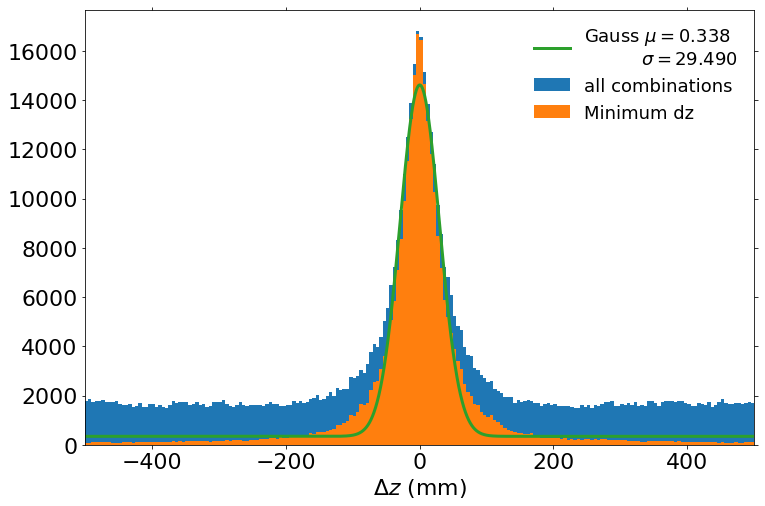

In [39]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(12, 8)

z_lim = 500
_ =                           ax.hist(1e3*delta_zs_all[np.abs(1e3*delta_zs_all) < z_lim], 200, label='all combinations')
bin_heights, bin_borders, _ = ax.hist(1e3*delta_zs_min[np.abs(1e3*delta_zs_min) < z_lim], 200, label='Minimum dz')

bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
popt, _ = curve_fit(gaussian, bin_centers, bin_heights, p0=[10000., 0., 30, 0])

#Plot fit
x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 10000)
ax.plot(x_interval_for_fit, gaussian(x_interval_for_fit, *popt), lw=3, label='Gauss $\\mu={:.3f}$\n          $\\sigma={:.3f}$'.format(popt[1], popt[2]))


ax.set_xlim(-z_lim, z_lim)
ax.set_xlabel('$\\Delta z$ (mm)')
ax.legend(frameon=False)